In [1]:
#Trocar inline para notebook ativa a interatividade nos gráficos
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing   import scale
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabaz_score
from sklearn.neighbors import NearestNeighbors

In [2]:
def rotate():
    verticalDir = 1
    elev = 10.
    for ii in range(1,360,1):
        if ii%40 == 0:
            verticalDir *= -1
        elev += verticalDir
        ax.view_init(elev=elev, azim=ii)
        axScaled.view_init(elev=elev, azim=ii)
        fig.canvas.draw()
        figScaled.canvas.draw()
        
def plot(xs, ys, zs, c, s, cmap='gnuplot', size=(8, 6)):
    fig = plt.figure(figsize=size)
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(elev=45, azim=45)
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    ax.set_zlabel('Profundidade')
    sc = ax.scatter(xs, ys, zs, c=c,s=s, cmap=plt.cm.get_cmap(cmap), 
                                                            depthshade=False)
    return ax, sc

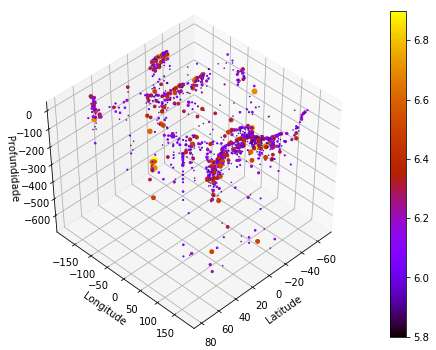

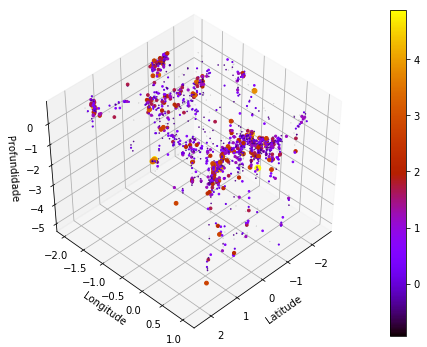

In [3]:
# Carrega um DataFrame com os dados do arquivo
cols = ['Profundidade', 'Latitude', 'Longitude', 'Magnitude']
df = pd.io.parsers.read_csv('quakes.csv', ',', header=None, names=cols )
# Prepara um DataFrame estandardizado
dfScaled = pd.DataFrame(data=scale(df.values), columns=cols)

n = len(df)

xs = np.ndarray((n,), buffer=np.array(df['Latitude']))
ys = np.ndarray((n,), buffer=np.array(df['Longitude']))
zs = np.ndarray((n,), buffer=np.array(df['Profundidade']*-1), dtype=int)
ss = np.ndarray((n,), buffer=np.array(df['Magnitude']))
ax, sc = plot(xs, ys, zs, ss, (ss-5.8)**2*30)
plt.colorbar(sc)

xs = np.ndarray((n,), buffer=np.array(dfScaled['Latitude']))
ys = np.ndarray((n,), buffer=np.array(dfScaled['Longitude']))
zs = np.ndarray((n,), buffer=np.array(dfScaled['Profundidade']*-1))
ss = np.ndarray((n,), buffer=np.array(dfScaled['Magnitude']))
axScaled, scScaled = plot(xs, ys, zs, ss, (ss+1)**2)
plt.colorbar(scScaled)

#rotate()
plt.show()

Acima, dois gráficos dos dados distribuídos no espaço com tamanho e cor proporcional a sua magnitude, o segundo gráfico representa valores estandardizados

## Rode o K-means para *K=2..10*, use *random_state=1*, e imprima a silueta média e o índice de Calinski-Harabaz. Qual parece ser o melhor valor para K?

In [4]:
for k in range(2, 11):
    km = KMeans(k, random_state=1, n_jobs=3)
    km.fit(dfScaled)
    print('k={}\tSilhouette score:{:.2f}\tCalinski Harabaz score: {:.2f}'
          .format(k, silhouette_score(dfScaled, km.labels_, random_state=1), 
                                calinski_harabaz_score(dfScaled, km.labels_)))
    #plot(xs, ys, zs, km.labels_, (ss+1)**2, 'Set1')
    #plt.show()

k=2	Silhouette score:0.32	Calinski Harabaz score: 675.01
k=3	Silhouette score:0.35	Calinski Harabaz score: 785.77
k=4	Silhouette score:0.34	Calinski Harabaz score: 866.58
k=5	Silhouette score:0.34	Calinski Harabaz score: 957.38
k=6	Silhouette score:0.36	Calinski Harabaz score: 1002.26
k=7	Silhouette score:0.37	Calinski Harabaz score: 971.10
k=8	Silhouette score:0.36	Calinski Harabaz score: 949.09
k=9	Silhouette score:0.36	Calinski Harabaz score: 939.45
k=10	Silhouette score:0.36	Calinski Harabaz score: 924.38


Aparentemente o melhor k fica entre 6 e 7, onde a primeira opção seria seguindo Calinski-Harabaz e a segunda a Silhoueta.

## Talvez os dados de latitude e longitude estão estragando a clusterização. Remova essa colunas e repita a tarefa acima e discuta os resultados.

In [5]:
dfNoCoord = dfScaled.copy()
del dfNoCoord['Latitude']
del dfNoCoord['Longitude']

for k in range(2, 11):
    km = KMeans(k, random_state=1, n_jobs=3)
    km.fit(dfNoCoord)
    print('k={}\tSilhouette score:{:.2f}\tCalinski Harabaz score: {:.2f}'
          .format(k, silhouette_score(dfNoCoord, km.labels_, random_state=1), 
                                 calinski_harabaz_score(dfNoCoord, km.labels_)))

k=2	Silhouette score:0.70	Calinski Harabaz score: 1483.64
k=3	Silhouette score:0.58	Calinski Harabaz score: 3087.43
k=4	Silhouette score:0.51	Calinski Harabaz score: 3216.86
k=5	Silhouette score:0.53	Calinski Harabaz score: 3125.96
k=6	Silhouette score:0.51	Calinski Harabaz score: 3160.03
k=7	Silhouette score:0.49	Calinski Harabaz score: 3101.35
k=8	Silhouette score:0.49	Calinski Harabaz score: 3156.70
k=9	Silhouette score:0.50	Calinski Harabaz score: 3181.74
k=10	Silhouette score:0.52	Calinski Harabaz score: 3362.36


Desconsiderando as coordenadas temos que com a silhoueta o melhor cenário é dado com 2 clusteres, já Calinski-Harabaz tem melhor pontuação com o maior número testado, 10 clusteres.

## Rode a clusterização hierárquica (método Ward) para 2..10 clusters para os dados de 4 dimensões e calcule os 2 índices acima. Qual os melhores valores do número de clusters?

In [6]:
for k in range(2, 11):
    ward = AgglomerativeClustering(n_clusters=k, linkage='ward')
    ward.fit(dfScaled)
    print('k={}\tSilhouette score:{:.2f}\tCalinski Harabaz score: {:.2f}'
          .format(k, silhouette_score(dfScaled, ward.labels_, random_state=1), 
                                 calinski_harabaz_score(dfScaled, ward.labels_)))
    

k=2	Silhouette score:0.31	Calinski Harabaz score: 536.44
k=3	Silhouette score:0.33	Calinski Harabaz score: 698.08
k=4	Silhouette score:0.26	Calinski Harabaz score: 731.08
k=5	Silhouette score:0.29	Calinski Harabaz score: 771.95
k=6	Silhouette score:0.31	Calinski Harabaz score: 750.03
k=7	Silhouette score:0.31	Calinski Harabaz score: 741.82
k=8	Silhouette score:0.31	Calinski Harabaz score: 733.85
k=9	Silhouette score:0.31	Calinski Harabaz score: 745.43
k=10	Silhouette score:0.32	Calinski Harabaz score: 749.07


O resultado é em partes similar ao anterior, silhouette foi melhor considerando menos clusteres, no caso 3, e Calinski-Harabaz teve seu melhor resultado com 5 clusteres.

## Rode o DBScan nos dados de 4 dimensões. Use *min_samples=5*. Construa o gráfico da distância dos *5-NN* e descubra o valor do EPS. Qual o número de clusters? Calcule os índices acima para os clusteres.

eps=0.54 	k=12	Silhouette score:-0.13	Calinski Harabaz score: 52.77
eps=0.1 	k=57	Silhouette score:-0.31	Calinski Harabaz score: 10.07
eps=0.2 	k=51	Silhouette score:-0.14	Calinski Harabaz score: 29.14
eps=0.3 	k=43	Silhouette score:-0.07	Calinski Harabaz score: 46.00
eps=0.4 	k=38	Silhouette score:-0.04	Calinski Harabaz score: 63.21
eps=0.5 	k=33	Silhouette score:-0.16	Calinski Harabaz score: 56.54
eps=0.6 	k=10	Silhouette score:-0.00	Calinski Harabaz score: 68.25
eps=0.7 	k=7	Silhouette score:0.08	Calinski Harabaz score: 94.44
eps=0.8 	k=5	Silhouette score:0.19	Calinski Harabaz score: 41.05
eps=0.9 	k=3	Silhouette score:0.29	Calinski Harabaz score: 45.10
eps=1.0 	k=1	Silhouette score:0.50	Calinski Harabaz score: 51.31
eps=1.1 	k=1	Silhouette score:0.51	Calinski Harabaz score: 32.99
eps=1.2 	k=1	Silhouette score:0.51	Calinski Harabaz score: 32.99
eps=1.3 	k=1	Silhouette score:0.47	Calinski Harabaz score: 15.33
eps=1.4 	k=1	Silhouette score:0.47	Calinski Harabaz score: 14.98


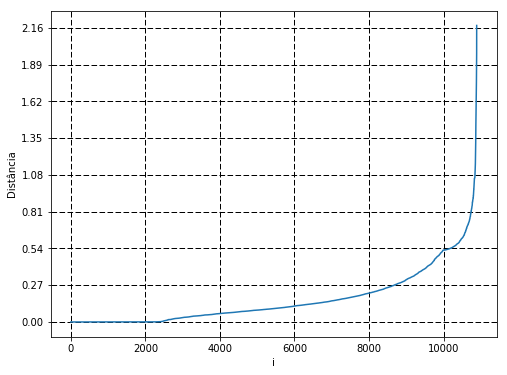

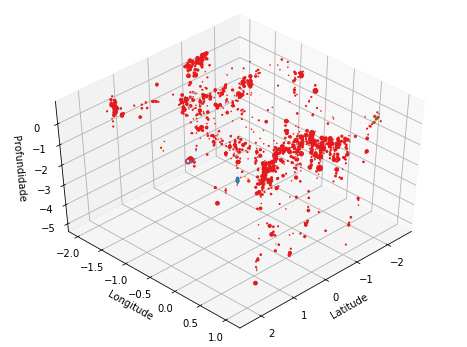

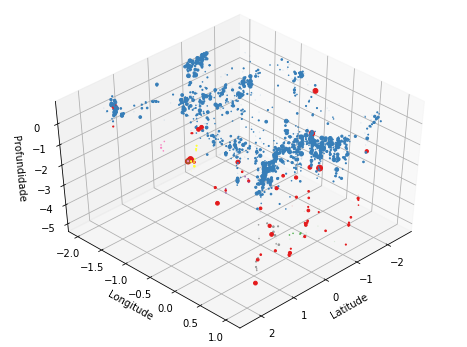

In [7]:
nbrs = NearestNeighbors(n_neighbors=5).fit(dfScaled)
distances, indices = nbrs.kneighbors(dfScaled)
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

ax.set_xlabel('i')
ax.set_ylabel('Distância')
x = range(len(distances)*5)
distances = sorted(distances.flatten())

ax.set_xticks(np.arange(0, 11000, 2000))
ax.set_yticks(np.arange(0, 3., 0.27))
ax.grid(color='black', linestyle='--', linewidth=1)
ax.plot(x, distances)

def dbscanScore(eps):
    dbscan = DBSCAN(min_samples=5, eps=eps, n_jobs=3)
    dbscan.fit(dfScaled)
    n_clusters_ = len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0)

    print('eps={} \tk={}\tSilhouette score:{:.2f}\tCalinski Harabaz score: {:.2f}'
          .format(eps, n_clusters_, 
                    silhouette_score(dfScaled, dbscan.labels_, random_state=1), 
                            calinski_harabaz_score(dfScaled, dbscan.labels_)))
    return dbscan.labels_

labels = dbscanScore(0.54)
plot(xs, ys, zs, labels, (ss+1)**2, 'Set1')

for i in range(10, 150, 10):
    labels = dbscanScore(i/100.0)
    if i == 70: # Valor definido manualmente com base nos resultados
        plot(xs, ys, zs, labels, (ss+1)**2, 'Set1')
    
plt.show()


Olhando o joelho no gráfico, imagina-se que um $\epsilon$ seria *0.54*, mas como podemos ver nos resultados, 0.7 se mostrou bem melhor (Visível no segundo gráfico), quanto ao número de clusteres, manteve-se a margem do que foi obtido até então, com 12 clusteres tomando $\epsilon=0.54$ e 7 com $\epsilon=0.7$. A pontuação por silhouette aumenta inversamente proporcional a quantidade de clusteres, alcançando seu máximo com um cluster, apenas.

# Discuta quantos clusters você acha apropriado para esse problema.
Analisando os primeiros gráficos, com latitude e longitude, no meu ponto de vista existem 4 clusteres bem definidos e mais 3 pequenos agrupamentos. Isso se mostrou uma análise razoável durante o trabalho, já que ocasionalmente aparecem valores próximos à 7.
Contudo se latitude e longitude forem mais importantes na caracterização de dados, os dados são muito bem caracterizados com 2 clusteres, como indicam as pontuações por silueta.  
É difícil avaliar esses dados sem entender a escala de Richter, pois esta leva em conta a distância para determinar a força de um terremoto, ou seja, com maior conhecimento seria possível aproveitar melhor a relação desta com as outras 3 dimensões.